# Lets Split the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import os
from tqdm.notebook import tqdm
import tensorflow as tf

In [2]:
orig = 512
sz = 256
reduce = orig//sz  #reduce the original images by 'reduce' times 
MASKS = '../input/hubmap-kidney-segmentation/train.csv'
DATA = '../input/hubmap-kidney-segmentation/train/'
s_th = 40  #saturation blancking threshold
p_th = 200*sz//256 #threshold for the minimum number of pixels

In [3]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        print("m: ",m,"len s: ",len(s))
        for i in range(len(s)//2):
            if (int(s[2*i]) - 1) < 0:
                print("Here should be the issue")
                
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
        print("Error is not here")
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

df_masks = pd.read_csv(MASKS).set_index('id')
df_masks.head()

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
8242609fa  96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc  61271840 4 61303134 13 61334428 22 61365722 30...

In [4]:
# The following function can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(image, mask):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'image': _bytes_feature(image),
      'mask': _bytes_feature(mask),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [5]:
os.makedirs('train')

In [6]:
def pad(a, shape):
    """
    array: Array to be padded
    reference: Reference array with the desired shape
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    """
    result = np.zeros(shape)
    result[:a.shape[0],:a.shape[1],:a.shape[2]] = a
    return result


from skimage import transform, io
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = 100000000000

def generateData(st,end,df_masks):    
    orig = 512
    sz = 256
    reduce = orig//sz  #reduce the original images by 'reduce' times 
    MASKS = '../input/hubmap-kidney-segmentation/train.csv'
    DATA = '../input/hubmap-kidney-segmentation/train/'
    s_th = 40  #saturation blancking threshold
    p_th = 200*sz//256 #threshold for the minimum number of pixels

    x_tot,x2_tot = [],[]
    ct = 0
    for index, encs in tqdm(df_masks.iterrows()):
        #read image and generate the mask
        #img = tiff.imread()
        ct += 1
        if ct<st or ct >= end:
            continue

        img_path = os.path.join(DATA,index+'.tiff')
        try:
          img = io.imread(img_path).squeeze()
        except:
          img = io.imread(img_path, plugin='pil').squeeze()

        print("count: ",ct)
        print(index,img.shape)
        if len(img.shape) == 5:img = np.transpose(img.squeeze(), (1,2,0))
        mask = enc2mask(encs,(img.shape[1],img.shape[0]))

        print("after mask ",index,img.shape)
        #add padding to make the image dividable into tiles
        shape = img.shape
        pad0 = (reduce*sz - shape[0]%(reduce*sz))%(reduce*sz)
        pad1 = (reduce*sz - shape[1]%(reduce*sz))%(reduce*sz)
        
        #print("padding  found")
        img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                    constant_values=0)
        #print("padded img")
        mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2]],
                    constant_values=0)
        print("Pad0 : ",pad0," pad1: ",pad1)
    #     img = pad(img,reqShape)
    #     img = pad(mask,reqShape)

        #print("after padding",index,img.shape)
        '''
        size of first image here :

        2f6ecfcdf Img shape is: (31744, 26624, 3)

        2f6ecfcdf Mask shape is: (31744, 26624)
        '''

        #split image and mask into tiles using the reshape+transpose trick
        img = cv2.resize(img,(img.shape[1]//reduce,img.shape[0]//reduce),
                         interpolation = cv2.INTER_AREA)
        img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
        img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)


        mask = cv2.resize(mask,(mask.shape[1]//reduce,mask.shape[0]//reduce),
                          interpolation = cv2.INTER_NEAREST)
        mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz)
        mask = mask.transpose(0,2,1,3).reshape(-1,sz,sz)

        '''
            2f6ecfcdf Img shape is: (806, 256, 256, 3)
            2f6ecfcdf Mask shape is: (806, 256, 256)
        '''
        print(index,"Img Count:",img.shape[0])


        filename = 'train/'+ index + '.tfrec'
        cnt = 0
        with tf.io.TFRecordWriter(filename) as writer:
            for i,(im,m) in enumerate(zip(img,mask)):
                #remove black or gray images based on saturation check
                hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
                h, s, v = cv2.split(hsv)
                if (s>s_th).sum() <= p_th or im.sum() <= p_th: continue

    #             x_tot.append((im/255.0).reshape(-1,3).mean(0))
    #             x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))

                im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
                example = serialize_example(im.tobytes(),m.tobytes())
                writer.write(example)

                cnt +=1
        #os.rename(filename,'train/'+ index + '-'+str(img.shape[0]) +'.tfrec') # old dataset version with issue         
        os.rename(filename,'train/'+ index + '-'+str(cnt) +'.tfrec')


    #image stats
    # img_avr =  np.array(x_tot).mean(0)
    # img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
    # print('mean:',img_avr, ', std:', img_std)

    # 4ef6695ce 

In [7]:
# 1:11
# 11:16
generateData(11,16,df_masks)
generateData(1,11,df_masks)

|          | 0/? [00:00<?, ?it/s]

count:  11
4ef6695ce (39960, 50680, 3)
m:  0 len s:  327014
Error is not here
after mask  4ef6695ce (39960, 50680, 3)
Pad0 :  488  pad1:  8
4ef6695ce Img Count: 7821
count:  12
26dc41664 (38160, 42360, 3)
m:  0 len s:  188702
Error is not here
after mask  26dc41664 (38160, 42360, 3)
Pad0 :  240  pad1:  136
26dc41664 Img Count: 6225
count:  13
c68fe75ea (26840, 49780, 3)
m:  0 len s:  91840
Error is not here
after mask  c68fe75ea (26840, 49780, 3)
Pad0 :  296  pad1:  396
c68fe75ea Img Count: 5194
count:  14
afa5e8098 (36800, 43780, 3)
m:  0 len s:  185840
Error is not here
after mask  afa5e8098 (36800, 43780, 3)
Pad0 :  64  pad1:  252
afa5e8098 Img Count: 6192
count:  15
1e2425f28 (26780, 32220, 3)
m:  0 len s:  136526
Error is not here
after mask  1e2425f28 (26780, 32220, 3)
Pad0 :  356  pad1:  36
1e2425f28 Img Count: 3339


|          | 0/? [00:00<?, ?it/s]

count:  1
2f6ecfcdf (31278, 25794, 3)
m:  0 len s:  83376
Error is not here
after mask  2f6ecfcdf (31278, 25794, 3)
Pad0 :  466  pad1:  318
2f6ecfcdf Img Count: 3162
count:  2
8242609fa (31299, 44066, 3)
m:  0 len s:  322166
Error is not here
after mask  8242609fa (31299, 44066, 3)
Pad0 :  445  pad1:  478
8242609fa Img Count: 5394
count:  3
aaa6a05cc (18484, 13013, 3)
m:  0 len s:  47606
Error is not here
after mask  aaa6a05cc (18484, 13013, 3)
Pad0 :  460  pad1:  299
aaa6a05cc Img Count: 962
count:  4
cb2d976f4 (34940, 49548, 3)
m:  0 len s:  202080
Error is not here
after mask  cb2d976f4 (34940, 49548, 3)
Pad0 :  388  pad1:  116
cb2d976f4 Img Count: 6693
count:  5
b9a3865fc (31295, 40429, 3)
m:  0 len s:  251194
Error is not here
after mask  b9a3865fc (31295, 40429, 3)
Pad0 :  449  pad1:  19
b9a3865fc Img Count: 4898
count:  6
b2dc8411c (14844, 31262, 3)
m:  0 len s:  68774
Error is not here
after mask  b2dc8411c (14844, 31262, 3)
Pad0 :  4  pad1:  482
b2dc8411c Img Count: 1798
count

In [8]:
#Count Number of images 
import re
import glob

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

train_images = glob.glob('train/*.tfrec')
ctraini = count_data_items(train_images)
print(f'Num train images: {ctraini}')

Num train images: 38593


# Retreive Dataset from TfRecords

In [9]:
DIM = sz
mini_size = 64
def _parse_image_function(example_proto):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string)
    }
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.reshape( tf.io.decode_raw(single_example['image'],out_type=np.dtype('uint8')), (DIM,DIM, 3))
    mask =  tf.reshape(tf.io.decode_raw(single_example['mask'],out_type='bool'),(DIM,DIM,1))
    
    image = tf.image.resize(image,(mini_size,mini_size))/255.0
    mask = tf.image.resize(tf.cast(mask,'uint8'),(mini_size,mini_size))
    return image, mask


def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(lambda ex: _parse_image_function(ex))
    return dataset

N = 8
def get_dataset(FILENAME):
    dataset = load_dataset(FILENAME)
    dataset = dataset.batch(N*N)
    return dataset

# Display Some dataset

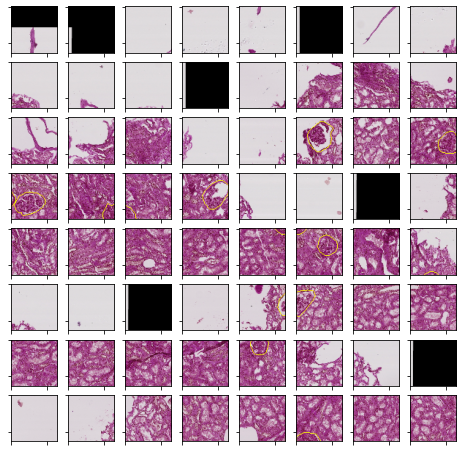

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.segmentation import mark_boundaries
for imgs, masks in get_dataset(train_images[0]).take(1):
    pass

plt.figure(figsize = (N,N))
gs1 = gridspec.GridSpec(N,N)

for i in range(N*N):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(mark_boundaries(imgs[i], masks[i].numpy().squeeze().astype('bool')))

plt.show()